In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

%matplotlib inline

In [2]:
PATH = Path('.')

In [3]:
device = "cuda:6" if torch.cuda.is_available() else "cpu"

In [4]:
tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])

In [5]:
train_ds = datasets.MNIST(PATH / "MNIST", train=True, transform=tfms, download=True)
test_ds = datasets.MNIST(PATH / "MNIST", train=False, transform=tfms, download=True)

In [6]:
train_dl = data.DataLoader(train_ds, batch_size=60)
test_dl = data.DataLoader(test_ds, batch_size=60, shuffle=False)

In [7]:
def plot_mnist(images, shape):
    fig = plt.figure(figsize=shape[::-1], dpi=80)
    for j in range(1, len(images) + 1):
        ax = fig.add_subplot(shape[0], shape[1], j)
        ax.matshow(images[j - 1, 0, :, :], cmap = matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    plt.show()
    

In [8]:
class ConvolutionalAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),  # 16 x 28 x 28
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),  # 16 x 14 x 14
            nn.Conv2d(16, 32, 3, padding=1),  # 32 x 14 x 14
            nn.Tanh(),
            nn.MaxPool2d(2, stride=2),  # 32 x 7 x 7
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2), # 16 x 15 x 15
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, padding=2, stride=2, output_padding=1), # 1 x 28 x 28
            nn.Tanh()
        )
        self.optim = optim.Adam(self.parameters(), lr=1e-4)
        self._loss = None
        
    def forward(self, x):
        x =self.encoder(x)
        x = self.decoder(x)
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.mse_loss(output, target, **kwargs)
        return self._loss

In [9]:
ae = ConvolutionalAE().to(device)

In [10]:
%%time
for epoch in range(1, 101):
    train_loss = 0.
    train_size = len(train_dl)
    for data, _ in train_dl:
        ae.optim.zero_grad()
        data = data.to(device)
        output = ae(data)
        loss = ae.loss(output, data)
        loss.backward()
        ae.optim.step()
        train_loss += ae._loss.item()
    train_loss /= train_size
    print(f"Epoch {epoch}: {train_loss}")

Epoch 1: 0.24367491437494754
Epoch 2: 0.0522610787935555
Epoch 3: 0.03243054939061403
Epoch 4: 0.023787484984844922
Epoch 5: 0.019256322190165518
Epoch 6: 0.0165406136745587
Epoch 7: 0.014740063077770173
Epoch 8: 0.013455403110012412
Epoch 9: 0.012479706004261971
Epoch 10: 0.011734247115440667
Epoch 11: 0.011122970287688076
Epoch 12: 0.01060789378825575
Epoch 13: 0.010174382406286896
Epoch 14: 0.009805308050010354
Epoch 15: 0.00948010681103915
Epoch 16: 0.009199554353021085
Epoch 17: 0.008954521452076734
Epoch 18: 0.008737070587463676
Epoch 19: 0.008542590432334692
Epoch 20: 0.008367217287421227
Epoch 21: 0.008208168770186604
Epoch 22: 0.008062672410160303
Epoch 23: 0.007928445264231414
Epoch 24: 0.007803901152219623
Epoch 25: 0.007687470517121256
Epoch 26: 0.0075788218108937145
Epoch 27: 0.007477321994490921
Epoch 28: 0.007382683615200222
Epoch 29: 0.007293851230293512
Epoch 30: 0.00721019897935912
Epoch 31: 0.007130946604534984
Epoch 32: 0.007055961354635656
Epoch 33: 0.0069856282826

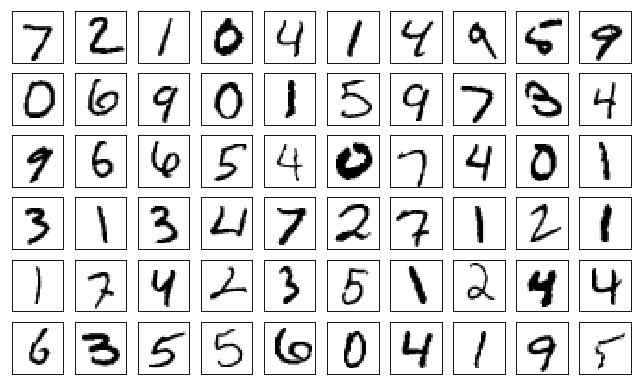

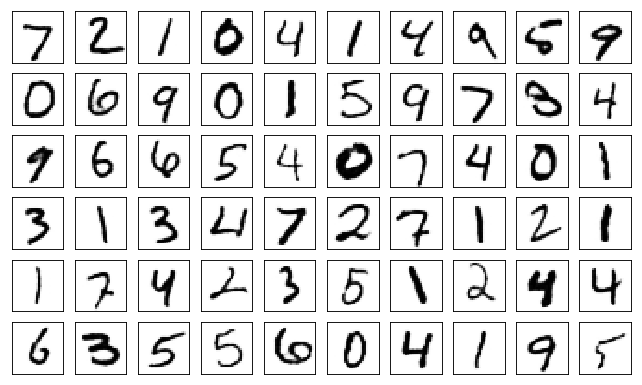

In [11]:
ae.eval()
img, _ = next(iter(test_dl))
output = ae(img.to(device))
plot_mnist(img, (6,10))
plot_mnist(output.data.cpu().numpy(), (6,10))

In [12]:
torch.save(ae.state_dict(), PATH / 'my_conv_ae.model')

## Fit image to specific actiovation pattern

In [13]:
class FitImageToActivationModel(nn.Module):
    def __init__(self, image, traget_activation, clip_fn=None):
        super().__init__()
        self.image = nn.Parameter(image)
        self.traget_activation = traget_activation
        self.optim = optim.Adam(self.parameters(), lr=1e-2)
        self._loss = None
        self.clip_fn = clip_fn if clip_fn else lambda x: x
        
    def forward(self, encoder):
        out = encoder(self.clip_fn(self.image))
        return out
    
    def loss(self, output):
        self._loss = F.mse_loss(output, self.traget_activation)
        return self._loss

### Target activation pattern

In [14]:
target_activation = torch.ones(7,7)
target_activation = target_activation[None, None, :, :]
target_activation = target_activation.expand(1,32,7,7)
target_activation = target_activation.to(device)
target_activation

tensor([[[[ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          ...,
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.]],

         [[ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          ...,
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.]],

         [[ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          ...,
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.]],

         ...,

         [[ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          [ 1.,  1.,  

### Plot original image

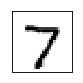

In [15]:
dl = torch.utils.data.DataLoader(test_ds, batch_size=1, shuffle=False) 
img, c = next(iter(dl))
plot_mnist(img, (1,1))

### Original activation pattern

In [16]:
ae.encoder(img.to(device))

tensor([[[[ 0.8260, -0.0577, -0.0577,  ..., -0.0577, -0.0577, -0.0459],
          [ 0.7968,  0.9456,  0.9854,  ...,  0.9633,  0.8889, -0.0085],
          [ 0.7968,  0.9507,  0.9870,  ...,  0.9999,  0.9991,  0.0144],
          ...,
          [ 0.7968, -0.0254, -0.0254,  ...,  0.9983, -0.0255, -0.0097],
          [ 0.7968, -0.0223,  0.9718,  ...,  0.8254, -0.0254, -0.0097],
          [ 0.7841,  0.0150,  0.9959,  ..., -0.0240, -0.0219,  0.0618]],

         [[ 0.2733,  0.2963,  0.2963,  ...,  0.2963,  0.2963,  0.2509],
          [ 0.2072,  0.2207,  0.2204,  ...,  0.2362,  0.2542,  0.2274],
          [ 0.1618, -0.4057, -0.6632,  ..., -0.7421,  0.2018,  0.2274],
          ...,
          [ 0.2127,  0.2405,  0.2455,  ...,  0.2356,  0.2475,  0.2274],
          [ 0.2127,  0.2405,  0.2657,  ...,  0.2491,  0.2503,  0.2274],
          [ 0.2214,  0.2479, -0.6222,  ...,  0.2563,  0.2479,  0.2382]],

         [[-0.6633, -0.7240, -0.7240,  ..., -0.7240, -0.7240, -0.7090],
          [-0.7363, -0.7722, -

### optimize image

In [17]:
ae.eval()

models = {
    'no_clip': FitImageToActivationModel(img, target_activation),
    'sigmoid': FitImageToActivationModel(img, target_activation, F.sigmoid),
    'tanh': FitImageToActivationModel(img, target_activation, F.tanh)
}

for m in models:
    models[m].to(device).train()

for i in range(1, 20_001):
    losses = [0.0]*len(models)
    for j , m in enumerate(models.values()):
        m.optim.zero_grad()
        out = m(ae.encoder)
        loss = m.loss(out)
        loss.backward()
        m.optim.step()
        losses[j]+=loss.item()
    if i % 1000 == 0:
        s = [f"\t{m} = {losses[j]/1000.}\n" for j , m in enumerate(models)]
        line = f"{int(i/1000)}K iteration loss: \n{' '.join(s)}"
        print(line)
        losses = [0.0]*len(models)

1K iteration loss: 
	no_clip = 0.0003776881694793701
 	sigmoid = 0.0008344846367835998
 	tanh = 0.0005654972791671753

2K iteration loss: 
	no_clip = 0.00032268527150154116
 	sigmoid = 0.0008285601139068604
 	tanh = 0.0005584585070610047

3K iteration loss: 
	no_clip = 0.0002892587184906006
 	sigmoid = 0.0008270676136016846
 	tanh = 0.0005573417544364929

4K iteration loss: 
	no_clip = 0.0002665001749992371
 	sigmoid = 0.0008265634775161743
 	tanh = 0.0005571417808532715

5K iteration loss: 
	no_clip = 0.00025119349360466005
 	sigmoid = 0.0008263317942619324
 	tanh = 0.0005569427609443665

6K iteration loss: 
	no_clip = 0.00023678793013095855
 	sigmoid = 0.0008262068033218384
 	tanh = 0.0005569102168083191

7K iteration loss: 
	no_clip = 0.000227336049079895
 	sigmoid = 0.0008261362910270691
 	tanh = 0.0005568952560424805

8K iteration loss: 
	no_clip = 0.00021946723759174347
 	sigmoid = 0.0008260986208915711
 	tanh = 0.000556892991065979

9K iteration loss: 
	no_clip = 0.0002106559872

### Extract target image

In [18]:
target_imgs = {k: m.image.detach() for k, m in models.items()}
target_imgs['original']=img.to(device)

### Optimized activation pattern

In [20]:
{k: ae.encoder(target_img) for k, target_img in target_imgs.items()}

{'no_clip': tensor([[[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
           [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
           [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
           ...,
           [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
           [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
           [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000]],
 
          [[ 0.8174,  0.6965,  0.7856,  ...,  0.8231,  0.8998,  0.9999],
           [ 0.9999,  0.5913,  0.7651,  ...,  0.7610,  0.9998,  0.9998],
           [ 0.9050, -1.0000, -1.0000,  ..., -1.0000,  0.9590,  0.6701],
           ...,
           [ 0.8622,  0.8830,  0.8319,  ...,  0.8728,  1.0000,  0.9982],
           [ 0.6710,  0.6177,  0.7068,  ...,  1.0000,  0.7436,  0.7625],
           [-1.0000,  0.7870, -1.0000,  ...,  0.8532, -1.0000,  0.9999]],
 
          [[ 0.8671,  0.9988, -0.9972,  ...,  0.8950,  0.8667,  1.0000],
  

### Optimized image

original


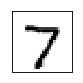

In [21]:
print('original')
plot_mnist(target_imgs['original'].view(-1, 1, 28, 28).data.cpu().numpy(), (1,1))

no_clip


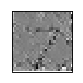

In [22]:
print('no_clip')
plot_mnist(target_imgs['no_clip'].view(-1, 1, 28, 28).data.cpu().numpy(), (1,1))

sigmoid


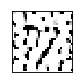

In [23]:
print('sigmoid')
plot_mnist(F.sigmoid(target_imgs['sigmoid']).view(-1, 1, 28, 28).data.cpu().numpy(), (1,1))

tanh


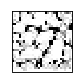

In [24]:
print('tanh')
plot_mnist(F.tanh(target_imgs['tanh']).view(-1, 1, 28, 28).data.cpu().numpy(), (1,1))

# Convolutional classifier

In [25]:
class ConvolutionalClassifier(nn.Module):
    def __init__(self, lr = 1e-4):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),  
            nn.Conv2d(16, 32, 3, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)  
        )
        self.fc = nn.Sequential(
            nn.Linear(32*7*7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr)
    
    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 32*7*7)
        x = self.fc(x)
        out = F.log_softmax(x, dim=1)
        return out
    
    def loss(self, output, target):
        self._loss = F.nll_loss(output, target)
        return self._loss

In [26]:
clf = ConvolutionalClassifier().to(device)

In [27]:
%%time
for epoch in range(1, 21):
    train_loss = 0.
    train_size = len(train_dl)
    clf.train()
    for data, target in train_dl:
        clf.optim.zero_grad()
        data = data.to(device)
        target = target.to(device)
        output = clf(data)
        loss = clf.loss(output, target)
        loss.backward()
        clf.optim.step()
        train_loss += clf._loss.item()
    train_loss /= train_size
    print(f"Epoch {epoch}: {train_loss}")
    
    clf.eval()
    batch_size = 60
    test_loss = 0.
    test_size = len(test_dl) 
    correct = 0
    for data, target in test_dl:
        data = data.to(device)
        target = target.to(device)
        output = clf(data)
        _, pred = torch.max(output.data, 1)
        correct += (pred==target).sum().item()
        test_loss += clf.loss(output, target).item()
    test_loss /= test_size
    print(f"Test loss: {test_loss}, Accuracy: {correct}/{test_size * batch_size} {correct/(test_size * batch_size)}%")
        

Epoch 1: 0.5950024516638368
Test loss: 0.23418986745468692, Accuracy: 9327/10020 0.9308383233532934%
Epoch 2: 0.19007348302192986
Test loss: 0.13138366838314844, Accuracy: 9625/10020 0.9605788423153693%
Epoch 3: 0.12238531780336052
Test loss: 0.09063258818225255, Accuracy: 9730/10020 0.9710578842315369%
Epoch 4: 0.091119367250707
Test loss: 0.07228478526872231, Accuracy: 9772/10020 0.975249500998004%
Epoch 5: 0.07429287316813134
Test loss: 0.061360925677738536, Accuracy: 9802/10020 0.9782435129740519%
Epoch 6: 0.06348053688323126
Test loss: 0.05397064556157869, Accuracy: 9825/10020 0.9805389221556886%
Epoch 7: 0.05591966685501393
Test loss: 0.04862965194684102, Accuracy: 9838/10020 0.9818363273453093%
Epoch 8: 0.05015366866608383
Test loss: 0.04479215648108926, Accuracy: 9849/10020 0.982934131736527%
Epoch 9: 0.04546771218400682
Test loss: 0.04216753226448886, Accuracy: 9858/10020 0.9838323353293413%
Epoch 10: 0.041557492939755324
Test loss: 0.04030001375958056, Accuracy: 9863/10020 0.

In [28]:
torch.save(clf.state_dict(), PATH / 'my_conv_clf.model')

## Fit images from different classes to class 8

In [29]:
class FitImageToClassModel(nn.Module):
    def __init__(self, image, traget_class, clip_fn=None):
        super().__init__()
        self.image = nn.Parameter(image)
        self.target_class = torch.ones(image.shape[0], dtype=torch.long)*8
        self.target_class = self.target_class.to(device)
        self.optim = optim.Adam(self.parameters(), lr=1e-3)
        self._loss = None
        self.clip_fn = clip_fn if clip_fn else lambda x: x
        
    def forward(self, classifier):
        out = classifier(self.clip_fn(self.image))
        return out
    
    def loss(self, output):
        self._loss = F.nll_loss(output, self.target_class)
        return self._loss

### Print original images

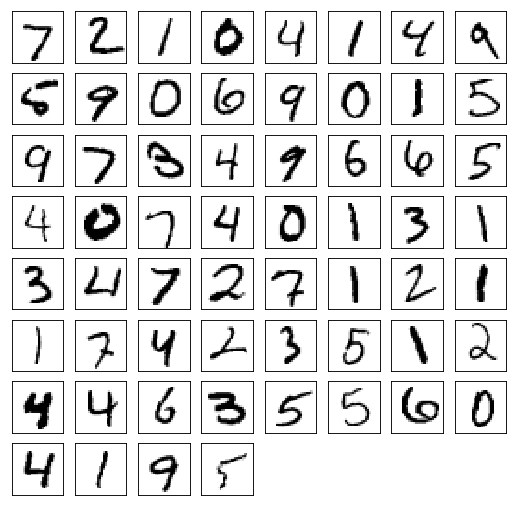

tensor([ 7,  2,  1,  0,  4,  1,  4,  9,  5,  9,  0,  6,  9,  0,
         1,  5,  9,  7,  3,  4,  9,  6,  6,  5,  4,  0,  7,  4,
         0,  1,  3,  1,  3,  4,  7,  2,  7,  1,  2,  1,  1,  7,
         4,  2,  3,  5,  1,  2,  4,  4,  6,  3,  5,  5,  6,  0,
         4,  1,  9,  5]) torch.Size([60])


In [30]:
imgs, c = next(iter(test_dl))
plot_mnist(imgs, (8,8))
print(c, c.shape)

### Optimize images

In [31]:
clf.eval()

models = {'no_clip': FitImageToClassModel(imgs, 8), 
          'sigmoid': FitImageToClassModel(imgs, 8, F.sigmoid),
          'tanh': FitImageToClassModel(imgs, 8, F.tanh)}
for m in models.values():
    m.to(device).train()

for i in range(1, 20_001):
    losses = [0.0]*len(models)
    for j , m in enumerate(models.values()):
        m.optim.zero_grad()
        out = m(clf)
        loss = m.loss(out)
        loss.backward()
        m.optim.step()
        losses[j]+=loss.item()
    if i % 1000 == 0:
        s = [f"\t{m} = {losses[j]/1000.}\n" for j , m in enumerate(models)]
        line = f"{int(i/1000)}K iteration loss: \n{' '.join(s)}"
        print(line)
        losses = [0.0]*len(models)

1K iteration loss: 
	no_clip = 8.348894305527211e-06
 	sigmoid = 3.35637740790844e-05
 	tanh = 1.4206401072442531e-05

2K iteration loss: 
	no_clip = 2.2960742935538293e-06
 	sigmoid = 9.356467053294182e-06
 	tanh = 3.5152672789990903e-06

3K iteration loss: 
	no_clip = 1.001119613647461e-06
 	sigmoid = 4.2340755462646485e-06
 	tanh = 1.45960645750165e-06

4K iteration loss: 
	no_clip = 5.137920379638671e-07
 	sigmoid = 2.245187759399414e-06
 	tanh = 7.302125450223684e-07

5K iteration loss: 
	no_clip = 2.851645112968981e-07
 	sigmoid = 1.2887398479506374e-06
 	tanh = 3.9626756915822624e-07

6K iteration loss: 
	no_clip = 1.6475518350489437e-07
 	sigmoid = 7.719357963651418e-07
 	tanh = 2.2475719742942602e-07

7K iteration loss: 
	no_clip = 9.748935553943738e-08
 	sigmoid = 4.7522384556941685e-07
 	tanh = 1.315116824116558e-07

8K iteration loss: 
	no_clip = 5.8380763221066446e-08
 	sigmoid = 2.9790401458740236e-07
 	tanh = 7.837613520678132e-08

9K iteration loss: 
	no_clip = 3.538131

### Extract optimized images

In [32]:
target_imgs = {k: m.image.detach() for k, m in models.items()}
target_imgs['original']=imgs.to(device)

### Classify and plot optimized images

In [33]:
{k: torch.argmax(clf(target_img), dim=1) for k, target_img in target_imgs.items()}

{'no_clip': tensor([ 8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
          8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
          8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
          8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
          8,  8,  8,  8], device='cuda:6'),
 'sigmoid': tensor([ 8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
          8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
          8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
          8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
          8,  8,  8,  8], device='cuda:6'),
 'tanh': tensor([ 8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
          8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
          8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
          8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
          8,  8,  8,  8], device='cuda:6'),
 'original': tensor([ 7,  2,  1,  0,  4,  1,  4,  9,  5,  

original


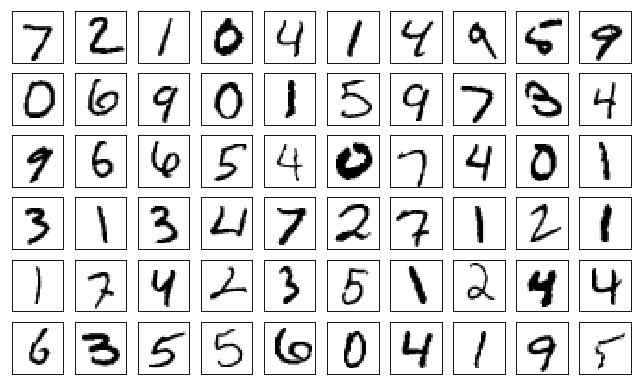

In [34]:
print('original')
plot_mnist(target_imgs['original'].view(-1, 1, 28, 28).data.cpu().numpy(), (6,10))

no_clip


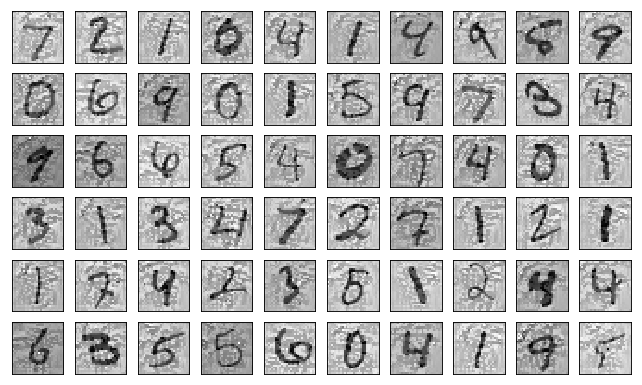

In [35]:
print('no_clip')
plot_mnist(target_imgs['no_clip'].view(-1, 1, 28, 28).data.cpu().numpy(), (6,10))

sigmoid


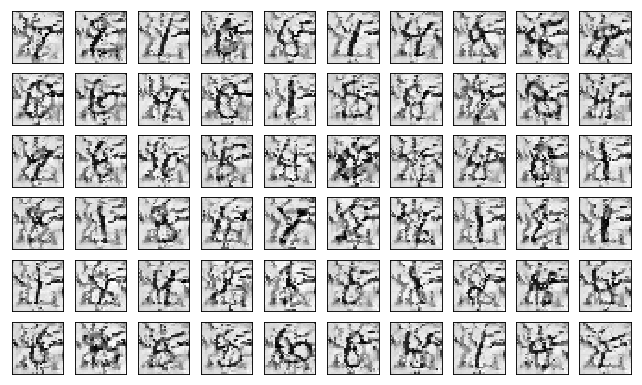

In [36]:
print('sigmoid')
plot_mnist(F.sigmoid(target_imgs['sigmoid']).view(-1, 1, 28, 28).data.cpu().numpy(), (6,10))

tanh


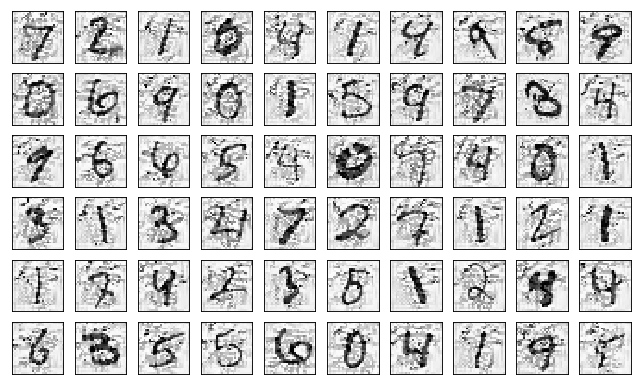

In [37]:
print('tanh')
plot_mnist(F.tanh(target_imgs['tanh']).view(-1, 1, 28, 28).data.cpu().numpy(), (6,10))